In [2]:
import fenics as fen
import mshr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
height = 5.0
width = 1.0
domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(height, width))
mesh = mshr.generate_mesh(domain, 200)
V = fen.FunctionSpace(mesh, 'P', 1)

In [4]:
class Walls(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (fen.near(x[0], 0) or fen.near(x[0], width))
    
class Inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0)

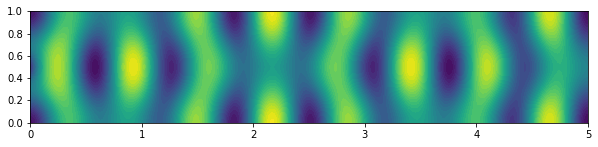

In [69]:
v = fen.TestFunction(V)
A = fen.TrialFunction(V)

dx = fen.Measure('dx', domain=mesh)

mu = 1.0 # 4*np.pi*1e-7
eps = 1.0 # 8.85418782e-12

a_stiff = (1/mu) * fen.dot(fen.grad(A), fen.grad(v))*dx
a_mass = eps*A*v*dx
omega = 10
a = a_stiff - omega**2 * a_mass

# Technique seen at https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html
boundary = fen.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
walls = Walls()
walls.mark(boundary, 1)
inlet = Inlet()
inlet.mark(boundary, 2)
ds = fen.Measure('ds', subdomain_data=boundary)

B_0 = 1
g_zro = fen.Constant(0.0)
g_cst = fen.Expression('-(1/mu)*B_0', degree=2, B_0=B_0, mu=mu)
g_exp = fen.Expression('-(1/mu)*B_0*exp(-pow(x[1] - 0.5, 2) / 0.01)', degree=2, B_0=B_0, mu=mu)
#L = g_cst*v*ds(2) + g_zro*v*ds(1)
L = g_exp*v*ds(2) + g_zro*v*ds(1)

A = fen.Function(V)
fen.solve(a == L, A)
plt.figure(figsize=(10, 3))
fen.plot(A)